# Validation of IEM Mixing Model w/ Reactions
## Goals:
    1. Total system mass must be conserved
    2. Total system enthalpy must be conserved
    3. Mass fractions for each reactor must sum up to 1 at all times. 

In [42]:
# Import required packages and tools: 
from collections import Counter
from cantera import Solution
from cantera._cantera import ConstPressureReactor, ReactorNet
from matplotlib.pyplot import plot, show
import matplotlib.pyplot as plt
from numpy.ma import array, arange
import pandas as pd
import numpy as np

# Create t vector
milliseconds = 0.001;
dt = 0.001*milliseconds;
tau_mix = 0.01*milliseconds;
omega = 1/tau_mix;
end_time = 1*milliseconds;
t = arange(0, end_time, dt)

%matplotlib notebook

plt.style.use('ggplot')
plt.style.use('seaborn-pastel')

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.autolayout'] = True

len(t)

1001

### Function to Create Reactor Network of Three Reactors: 

In [19]:
def createReactorNetwork():
#     m = array([6, 3, 1]);
#     s1 = Solution('h2o2.cti');
#     s2 = Solution('h2o2.cti');
#     s3 = Solution('h2o2.cti');

#     s1.TPX = 300, 101325, 'H2:0.75, O2:0.25';
#     s2.TPX = [400, 101325, 'O2:0.75, H2:0.25'];
#     s3.TPX = [500, 101325, 'H2:0.5, O2:0.5'];
#     s3.equilibrate('HP');
#     tpArray = array([s1, s2, s3])
    m = array([4, 4, 2]);
    s1 = Solution('h2o2.cti');
    s2 = Solution('h2o2.cti');
    s3 = Solution('h2o2.cti');

    s1.TPY = 300, 101325, 'H2:1';
    s2.TPY = [300, 101325, 'O2:1'];
    s3.TPX = [300, 101325, 'H2:2, O2:1'];
    s3.equilibrate('HP');
    tpArray = array([s1, s2, s3])
    
    r1 = ConstPressureReactor(s1);
    r2 = ConstPressureReactor(s2);
    r3 = ConstPressureReactor(s3);
    rArray = array([r1, r2, r3])
    
    rn = ReactorNet([r1, r2, r3]);
    
    r1.syncState(); 
    r2.syncState(); 
    r3.syncState();
    rn.reinitialize()
    return m, tpArray, rArray, rn;

### IEM Mixing Model

In [20]:
def iem(m, tpArray, rArray, rn, dt, omega):
# Constant k:
    C_phi = 2;
    k = -C_phi * omega * 0.5 * dt;

# Calculate average: 
    m_total_r = 1/sum(m)
    H_total = 0; 
    M_species_total = array([0.00]*tpArray[0].n_species)
    for i in range(0,len(tpArray)):
        M_species_total += m[i] * tpArray[i].Y; # List of total mass across all reactors of each species
        H_total += m[i] * tpArray[i].enthalpy_mass

    Y_avg = M_species_total * m_total_r # Y_species_avg = (M_total_species)/(M_total_system)
    h_avg = H_total * m_total_r; # H_avg is the specific mass-weighted average across all reactors of the total enthalpy.
# Adjust reactor state:     
    for i in range(0, len(tpArray)):
        h = tpArray[i].enthalpy_mass;
        h_new = h + k * (h - h_avg);
        Y_current = tpArray[i].Y;
        Y_new =  Y_current + k * (Y_current - Y_avg); 
        tpArray[i].HPY = [h_new, tpArray[i].P, Y_new]
        rArray[i].syncState();

# Reinitialize reactor network solver:         
    rn.reinitialize();

In [21]:
m, tpArray, rArray, rn = createReactorNetwork(); 

# Create table
columnNames = ['T'] + ['P'] + ['Enthalpy'] + tpArray[0].species_names 
timeHistory = [pd.DataFrame(columns=columnNames) for i in range(0,len(tpArray))]

counter = 0
for i in range(0, len(t)):
    for j in range(0, len(tpArray)):
        if(counter%10 == 0):        
            state = np.hstack([rArray[j].thermo.T, rArray[j].thermo.P, m[j]*tpArray[j].enthalpy_mass, 
                               rArray[j].thermo.Y])
            timeHistory[j].loc[t[i]] = state
    counter += 1
    rn.advance(t[i])
    iem(m, tpArray, rArray, rn, dt, omega)

## Check Conservation of Energy 

Initial total enthalpy = 121616.702223 J
Final total enthalpy = 121622.315503 J


<IPython.core.display.Javascript object>


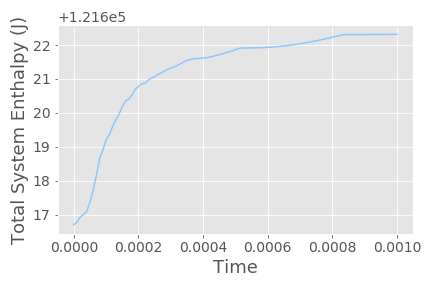

In [43]:
initial_total_enthalpy = timeHistory[0]['Enthalpy'][0] + \
                         timeHistory[1]['Enthalpy'][0] + \
                         timeHistory[2]['Enthalpy'][0]

print("Initial total enthalpy =", initial_total_enthalpy, "J")
# H_initial = array([initial_total_enthalpy]*len(t))

h_total = timeHistory[0]['Enthalpy'] + timeHistory[1]['Enthalpy'] + timeHistory[2]['Enthalpy']
h_final = h_total.get_value(h_total.last_valid_index());
print("Final total enthalpy =", h_final, "J")

plt.figure()
plt.plot(h_total.index, h_total)
plt.xlabel('Time');
plt.ylabel('Total System Enthalpy (J)');
# plt.ylim(ymin=(h_total[0]-3),ymax=(h_final+3))
# help(plt.ylim)

In [23]:
timeHistory[2].to_clipboard();

<IPython.core.display.Javascript object>


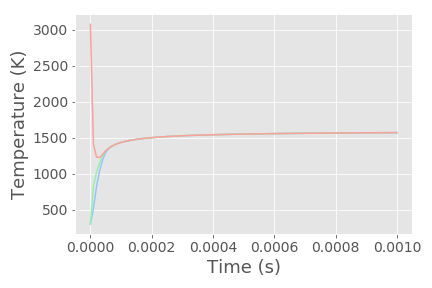

In [44]:
plt.figure()
plt.plot(timeHistory[0].index, timeHistory[0]['T'],
         timeHistory[1].index, timeHistory[1]['T'],
         timeHistory[2].index, timeHistory[2]['T']) 
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)');

In [32]:
timeHistory[2].to_clipboard()

## Varying Mixing Times 

In [25]:
tau_mix_list = array([0.001, 0.01, 0.10, 0.20])*milliseconds

mList = [None for i in range(0,len(tau_mix_list))]
tpArrayList = [None for i in range(0,len(tau_mix_list))]
rArrayList = [None for i in range(0,len(tau_mix_list))]
rnList = [None for i in range(0,len(tau_mix_list))]
for i in range(0,len(tau_mix_list)):
    mList[i], tpArrayList[i], rArrayList[i], rnList[i] = createReactorNetwork();     
# Create table
columnNames = ['T'] + ['P'] + ['Enthalpy'] + tpArrayList[0][0].species_names 
# histList = [None for i in range(0,len(tau_mix_list))]
histList = [[pd.DataFrame(columns=columnNames) for i in range(0,len(tpArrayList[0]))] for i in range(0,len(tau_mix_list))]

for i in range(0,len(tau_mix_list)):
    tauMix = tau_mix_list[i]; 
    omega = 1/tauMix;
    masses = mList[i]; # array of masses
    tps = tpArrayList[i]; # array of thermo managers
    rs = rArrayList[i]; # array of reactors
    reacNet = rnList[i]; # current reactorNetwork 
    
    counter = 0; 
    
    for k in range (0, len(t)):
        for j in range(0, len(tps)): 
            if (counter%10 == 0):
                state = np.hstack([rs[j].thermo.T, rs[j].thermo.P, masses[j]*tps[j].enthalpy_mass, 
                                   rs[j].thermo.Y])
                histList[i][j].loc[t[k]] = state

        counter += 1
        reacNet.advance(t[k])
        iem(masses, tps, rs, reacNet, dt, omega)

<IPython.core.display.Javascript object>


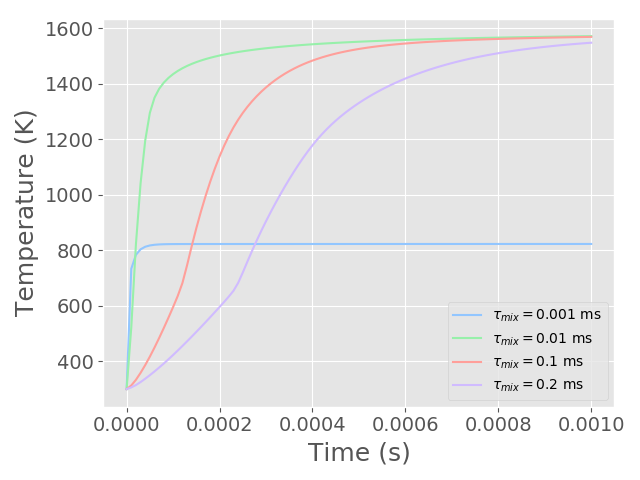

<IPython.core.display.Javascript object>


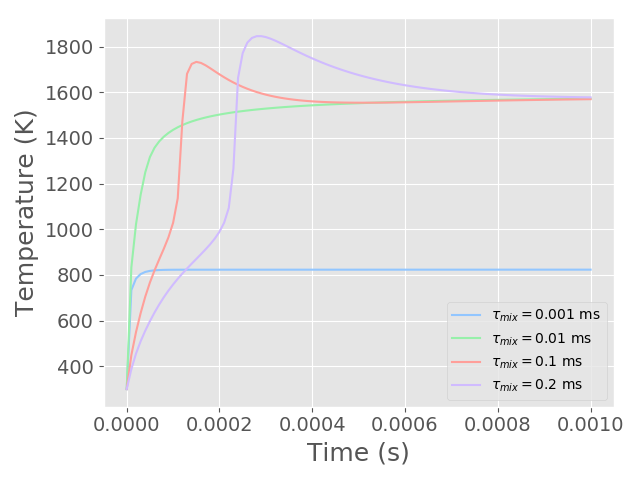

<IPython.core.display.Javascript object>


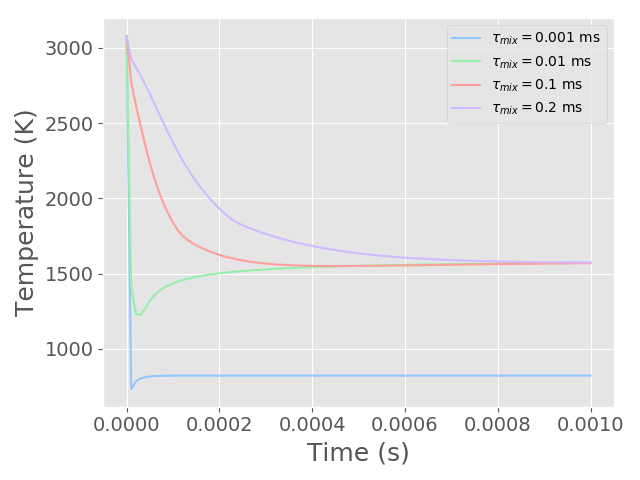

In [26]:
for j in range(0, len(tps)):
    plt.figure()
    for i in range(0, len(tau_mix_list)):
        plt.plot(histList[i][j].index, histList[i][j]['T'], label= r'$ \tau_{mix} = $' + str(tau_mix_list[i]/milliseconds) + ' ms');
    
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)');
    

In [27]:
# sum([timeHistory[i]['Enthalpy'] for i in range(0,len(timeHistory))])

<IPython.core.display.Javascript object>


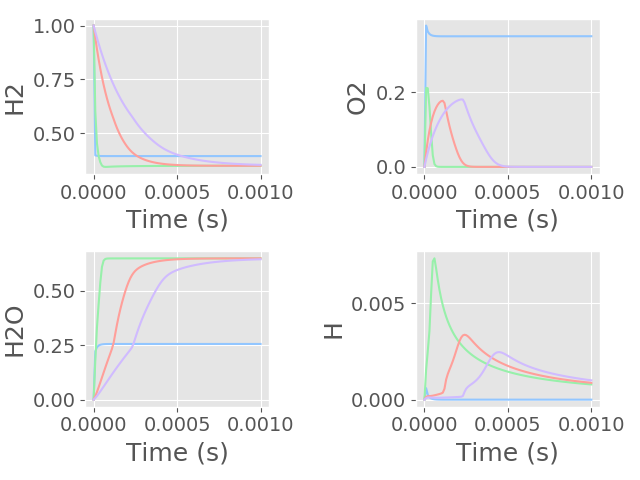

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


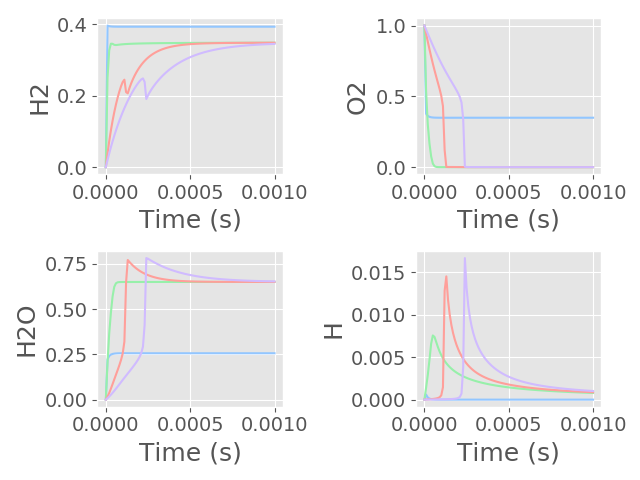

<IPython.core.display.Javascript object>


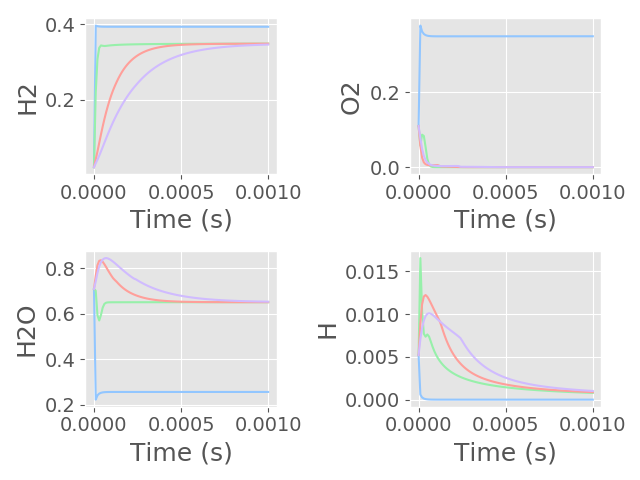

In [28]:
speciesList = ['H2', 'O2', 'H2O', 'H']
figNumber = [11, 12, 13, 14]
for j in range(0, len(tps)):
    plt.figure(figNumber[j]);
    for i in range(0, len(tau_mix_list)):
        for k in range(0, len(speciesList)):
            plt.subplot(len(speciesList)/2, len(speciesList)/2, k + 1)
            plt.plot(histList[i][j].index, histList[i][j][speciesList[k]]);
            plt.ylabel(speciesList[k]);
            plt.xlabel('Time (s)')
            

In [29]:
# help(plt.legend)
[r'$tau_{mix} = $' + str(tau_mix_list[0]/milliseconds) + ' ms']

['$tau_{mix} = $0.001 ms']